```Name: Wong Wen Bing```    
```Admin #: 230436M```  
```PEM GROUP: AA2303```

# About Objective: Classifying Birds
This is a series of jupyter notebooks aimed at using Python in conducting text classification in predicting the type of birds. 

In the dataset provided, there are 2 columns: description and species (4 species). This is hence a supervised learning problem due to the presence of labelled data.

In this problem, a fake positive / fake negative where the species are predicted wrongly, often carry severe consequences. As such, a good and accurate model must have a balance of sensitivity and specificity, as such F1 score will be used as the main metric here. 



# **Part 2: Text Feature Engineering and Modelling (2/3)**  
This notebook will cover the text feature engineering and modelling component, covering a wide range of vectorizers and models, and using different types of metrics to determine the best model.

Installing and Importing Libraries

In [1]:
# pip install scikit-learn seaborn nltk pandas numpy matplotlib wordcloud

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

import pickle
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import classification_report, f1_score


With the dataset now cleaned chunked, we can now use the dataset for our feature engineering and modelling.

In [3]:
df=pd.read_csv('cleaned_data.csv')
df.head()

,Unnamed: 0,cleaned,species
0,0,jun share similarity common myna term physical...,Javan Myna
1,1,click information red list category criterion ...,Collared Kingfisher
2,2,oriolus larvatus specie bird family oriolidae ...,Black-naped Oriole
3,3,search thousand royalty free stock image video...,Javan Myna
4,4,foreground recording background recording egre...,Little Egret


## **Section A. Generating Text Embeddings** 
In order for the model to work, the text have to be embedded through a series of vectorizers. Different types of embeddings will be trialled and tested. 

- Count Vectorizer
- TfIDF Vectorizer
- Top N Words Features

We now start by determing the X and Y variables first, with the X as the chunked text and Y as the species which is the target variable.

In [4]:
X = df['cleaned'] 
Y=df['species']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

### 1. Using Count Vectorizer with N-Grams of 2 and a limit on the maximum features
We now use the first method which is count vectorizer with an ngram range of 2, and a maximum features of 7000.

In [5]:
cv=CountVectorizer(ngram_range=(1,2), max_features=7000)
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test)
#print dimensions and features 
print(f"""
train: {X_train_cv.toarray().shape}
test: {X_test_cv.toarray().shape}
features: {cv.get_feature_names_out()}
      """)


train: (472, 7000)
test: (118, 7000)
features: ['ability' 'able' 'abundance' ... 'zhao renhui' 'zimbabwe'
 'zimbabwe zambia']
      


### 2. Using Tfifdf Vectorizer with N-grams of 2 and limit on maximum features
We now use the second method which is tfidf vectorizer with an ngram range of 2, and a maximum features of 7000.

In [ ]:
tv=TfidfVectorizer(ngram_range=(1,2), max_features=7000)
X_train_tv=tv.fit_transform(X_train)
X_test_tv=tv.transform(X_test)

#print dimensions and features 
print(f"""
train: {X_train_tv.toarray().shape}
test: {X_test_tv.toarray().shape}
features: {tv.get_feature_names_out()}
      """)


rain: (472, 7000)
test: (118, 7000)
features: ['ability' 'able' 'abundance' ... 'zhao renhui' 'zimbabwe'
 'zimbabwe zambia']
      


### 3. Using Top N words feature

In using the Top N words feature, we ascertain the number of features based on how frequent the word appears in the training set. This allows a greater relevance to the problem by selecting the most important words based on vocabulary which are more likely to influence the outcome. 


In [7]:
txt=df['cleaned'].tolist() #convert dataframe columns to list
txt=' '.join(txt)

<FreqDist with 3379 samples and 13751 outcomes>


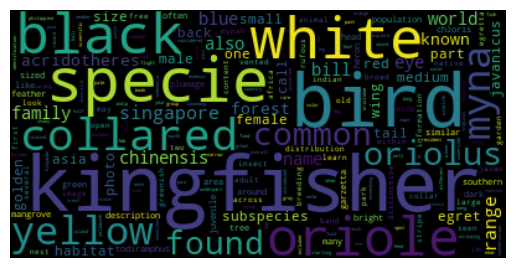

In [8]:
freq_dist=FreqDist(txt.split()) #calculate frequency of words that should be a list
print(freq_dist)
cloud=WordCloud().generate_from_frequencies(freq_dist) #generate word cloud
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
print(len(freq_dist))

3379


Based on the words above, we can observe words like black, oriole, kingfisher, singapore, oriolus are words that appear very frequently. We can use these words as influences.    

Also, there is not a need to use all the words in the given sample, as such it would be good to use the top 2000 words. 

In [10]:
top2k_words=freq_dist.most_common(2000)

In [11]:
def lissttt(string): 
    strings=[]
    x=string.split(' ')
    return x
df['text']=df['cleaned'].apply(lambda x:lissttt(x))

The function below is used to create a feature set to train the classifier. A feature extractor is defined as well to check if the words in the given document are present in the top2k words features.

In [12]:
def document_features(df, stemmed_tokens):
    doc_features = []
    for index, row in df.iterrows():
        features = {}
        for word in top2k_words:
            # get term occurence: true if it's in the word_features, false if it's not
            features[word] = (word in row[stemmed_tokens])
        doc_features.append(features)
    return doc_features

feature_set = pd.DataFrame(document_features(df, 'text'), index = df.index)
feature_set.head()

from sklearn.model_selection import train_test_split

x_doc=feature_set
y=df[df.columns[2]]
X_train_doc, X_test_doc, y_train_doc, y_test_doc=train_test_split(x_doc,y, test_size=0.2, random_state=42)

#### **Usage of A Base Model for testing**
As a base model, a Logistic Regression model is trained to examine the f1_score
We will use a base model, Logistic Regression to decide which of the vectorizers or bag of words features can produce the most results.

In [13]:
#train
def vectorise_data(X_train, X_test):
    lr=LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    y_pred=lr.predict(X_test)
    f1score=f1_score(y_test, y_pred,average='weighted')
    return f1score

print(f'''
Vectorizer: Count Vectorizer
F1-Score: {vectorise_data(X_train_cv, X_test_cv)} 
=================================================================================================

Vectorizer: Tfidf Vectorizer
F1-Score: {vectorise_data(X_train_tv, X_test_tv)}

=================================================================================================

Vectorizer: Top N words feature
F1-Score: {vectorise_data(X_train_doc,X_test_doc)}

''')



Vectorizer: Count Vectorizer
F1-Score: 0.8735010555868158 

Vectorizer: Tfidf Vectorizer
F1-Score: 0.8586235058995351


Vectorizer: Top N words feature
F1-Score: 0.20255283532119692




Based on the above models process, we can conclude that the top N words feature should not be used at all due to its extremely low F1 Score, but the count vectorizer and tfidf vectorizers can be evaluated further through a more comprehensive modelling process due to its rather similar scores.

## **Section B: Modelling**
In this modelling phase, different models will be used alongside the CountVectorized data and the TfIDFVectorized data. This is to test and see which model can be accurate and good.

Below are a list of models that will be done
1. Logistic Regression
2. Competent Naive Bayes: using a different form of naive bayes that is more suitable for an unbalanced dataset (https://scikit-learn.org/1.5/modules/naive_bayes.html#complement-naive-bayes)
3. Support Vector Machine
4. Decision Tree
5. Random Forest

#### **Using Count Vectorizers first**
Dataset: X_train_cv, X_test_cv, y_train, y_test

We now start by splitting the dataset first, using a training set of 80%, and test-size of 20%. 

Model 1: Logistic Regression

In [14]:
lr=OneVsRestClassifier(LogisticRegression(solver='lbfgs'))

#train
lr.fit(X_train_cv, y_train)

#apply to test
y_pred_cv=lr.predict(X_test_cv)
#get f1 score
f1score=f1_score(y_test, y_pred_cv,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_cv, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8735010555868158
                     precision    recall  f1-score   support

 Black-naped Oriole       0.93      0.89      0.91        44
Collared Kingfisher       1.00      0.96      0.98        25
         Javan Myna       0.73      0.92      0.81        26
       Little Egret       0.84      0.70      0.76        23

           accuracy                           0.87       118
          macro avg       0.87      0.87      0.87       118
       weighted avg       0.88      0.87      0.87       118



==> Given an F1 Score of 87.35%, this means that the predictions are often correct

Model 2 Naive Bayes (Complement NB)

In [15]:
cnb=ComplementNB()
cnb.fit(X_train_cv, y_train)
y_pred_cnb=cnb.predict(X_test_cv)
f1score=f1_score(y_test, y_pred_cnb,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_cnb, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8815002544813112
                     precision    recall  f1-score   support

 Black-naped Oriole       0.95      0.89      0.92        44
Collared Kingfisher       0.89      0.96      0.92        25
         Javan Myna       0.79      0.88      0.84        26
       Little Egret       0.86      0.78      0.82        23

           accuracy                           0.88       118
          macro avg       0.87      0.88      0.87       118
       weighted avg       0.88      0.88      0.88       118



==> With an f1 score of 88.15%, one of the better models so far.

Model 3: Linear Support Vector Machine 
- a linear support vector machine is known to be more accurate for text classification prediction features

In [16]:
lvc=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=15, tol=None)
lvc.fit(X_train_cv, y_train)
y_pred_lvc=lvc.predict(X_test_cv)
f1score=f1_score(y_test, y_pred_lvc,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_lvc, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8810031649300359
                     precision    recall  f1-score   support

 Black-naped Oriole       0.91      0.93      0.92        44
Collared Kingfisher       0.96      0.96      0.96        25
         Javan Myna       0.76      0.85      0.80        26
       Little Egret       0.89      0.74      0.81        23

           accuracy                           0.88       118
          macro avg       0.88      0.87      0.87       118
       weighted avg       0.88      0.88      0.88       118



==> With an F1 score of 88.10%, rather similar to performance of Naive Bayes

Model 3: Decision Tree Classifier

In [17]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_cv, y_train)
y_pred_dtree=dtree.predict(X_test_cv)
f1score=f1_score(y_test, y_pred_dtree,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_dtree, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8578160050608875
                     precision    recall  f1-score   support

 Black-naped Oriole       0.92      0.82      0.87        44
Collared Kingfisher       1.00      0.96      0.98        25
         Javan Myna       0.74      0.77      0.75        26
       Little Egret       0.75      0.91      0.82        23

           accuracy                           0.86       118
          macro avg       0.85      0.87      0.86       118
       weighted avg       0.87      0.86      0.86       118



==> With a rather low f1 score of 81.56%. 

Model 4: Random Forest Classifier

In [18]:
rf=RandomForestClassifier()
rf.fit(X_train_cv, y_train)
y_pred_rf=rf.predict(X_test_cv)
f1score=f1_score(y_test, y_pred_rf,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_rf, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8297314579507846
                     precision    recall  f1-score   support

 Black-naped Oriole       1.00      0.80      0.89        44
Collared Kingfisher       0.96      0.96      0.96        25
         Javan Myna       0.56      0.96      0.70        26
       Little Egret       1.00      0.57      0.72        23

           accuracy                           0.82       118
          macro avg       0.88      0.82      0.82       118
       weighted avg       0.89      0.82      0.83       118



==> F1 score of 83.32% is actually quite low, but still slightly higher than the Decision Tree Classifier

#### **Using TFIDF Vectorizer**

Dataset: X_train_tv, X_test_tv, y_train, y_test

We will now use TF-IDF vectorizer to train the models

Model 1: Logistic Regression

In [19]:
lr=OneVsRestClassifier(LogisticRegression(solver='lbfgs'))

#train
lr.fit(X_train_tv, y_train)

#apply to test
y_pred_lr=lr.predict(X_test_tv)
#get f1 score
f1score=f1_score(y_test, y_pred_lr,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_lr, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8371558793008728
                     precision    recall  f1-score   support

 Black-naped Oriole       0.80      0.98      0.88        44
Collared Kingfisher       1.00      0.96      0.98        25
         Javan Myna       0.76      0.85      0.80        26
       Little Egret       1.00      0.48      0.65        23

           accuracy                           0.85       118
          macro avg       0.89      0.82      0.83       118
       weighted avg       0.87      0.85      0.84       118



==> F1 Score of 83.71% slightly better than the one for Count Vectorizer, but still not performing that well as compared to Naive Bayes

Model 2: Naive Bayes

In [20]:
cnb=ComplementNB()
cnb.fit(X_train_tv, y_train)
y_pred_cnb=cnb.predict(X_test_tv)
f1score=f1_score(y_test, y_pred_cnb,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_cnb, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8800462941812478
                     precision    recall  f1-score   support

 Black-naped Oriole       0.93      0.93      0.93        44
Collared Kingfisher       0.86      0.96      0.91        25
         Javan Myna       0.81      0.85      0.83        26
       Little Egret       0.89      0.74      0.81        23

           accuracy                           0.88       118
          macro avg       0.87      0.87      0.87       118
       weighted avg       0.88      0.88      0.88       118



==> F1 Score of 88.00% is one of the best, but still performs slightly poorer than that of the models with features vectorized by count vectorizer

Model 3: Linear Support Vector Machine

In [21]:
lvc=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=15, tol=None)
lvc.fit(X_train_tv, y_train)
y_pred_lvc=lvc.predict(X_test_tv)
f1score=f1_score(y_test, y_pred_lvc,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_lvc, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8798496096018623
                     precision    recall  f1-score   support

 Black-naped Oriole       0.89      0.93      0.91        44
Collared Kingfisher       0.92      0.96      0.94        25
         Javan Myna       0.81      0.85      0.83        26
       Little Egret       0.89      0.74      0.81        23

           accuracy                           0.88       118
          macro avg       0.88      0.87      0.87       118
       weighted avg       0.88      0.88      0.88       118



==> F1 score of 87.98% is relatively good, and performs better than that of logistic regression or decision treee

Model 4: Decision Tree

In [22]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_tv, y_train)
y_pred_dtree=dtree.predict(X_test_tv)
f1score=f1_score(y_test, y_pred_dtree,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_dtree, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8584126427624506
                     precision    recall  f1-score   support

 Black-naped Oriole       0.88      0.82      0.85        44
Collared Kingfisher       1.00      0.96      0.98        25
         Javan Myna       0.88      0.81      0.84        26
       Little Egret       0.69      0.87      0.77        23

           accuracy                           0.86       118
          macro avg       0.86      0.86      0.86       118
       weighted avg       0.87      0.86      0.86       118



==> F1 score of 85.75% is performing better than the Decision Tree with features vectorized by the Count Vectorizer

In [23]:
rf=RandomForestClassifier()
rf.fit(X_train_tv, y_train)
y_pred_rf=rf.predict(X_test_tv)
f1score=f1_score(y_test, y_pred_rf,average='weighted')
print(f'f1 score: {f1score}')
print(classification_report(y_test, y_pred_rf, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

f1 score: 0.8337507228150965
                     precision    recall  f1-score   support

 Black-naped Oriole       0.93      0.86      0.89        44
Collared Kingfisher       1.00      0.96      0.98        25
         Javan Myna       0.61      0.85      0.71        26
       Little Egret       0.82      0.61      0.70        23

           accuracy                           0.83       118
          macro avg       0.84      0.82      0.82       118
       weighted avg       0.85      0.83      0.83       118



==> F1 score of 83.37% is surprising, as it bucks the trend in that this model performs better than the Random Forest with features vectorized by Count Vectorizer

## **Section C: Model Evaluation**
We can now evaluate the model performance through F1 Score and the results of the model as per the table below: 

| Model | CountVectorizer | TfIDF Vectorizer |
| --- | :---: | :----: | 
| Logistic Regression | 87.35%  | 83.71% |
| Complement Naive Bayes | 88.15% | 88.00% |
| Linear Support Vector Machine | 88.10% | 87.98% |
| Decision Tree | 81.56% | 85.75% |
| Random Forest | 83.32% | 83.37% |

We can now evaluate that the Complement Naive Bayes and Linear Support Vector Machine trained on CountVectorizer are the best models so far. Due to the small marginal difference in F1 Score, both models will thus be used for evaluating and used as the models to be tested for the 3rd part of this notebook, which is on the test data.   <br>


Surprisingly, Decision Tree and Random Forest models both bucked the trend whereby the models trained with TFIDF vectorizer had a higher F1 score than that of the model with features vectorized by Count Vectorizer. However, in general, both models are still one of the worser performing models. 


As for Linear Support Vector Machine and Complement Naive Bayes, these models regardless of whether its features are vectorized with TfiDF vectorizer or Count Vectorizer, they are still the best performing models, and their F1 scores are marginal differences in the different vectorized data.


Thus, for the last part in this series of notebooks, we will be implementinng the Complement Naive Bayes and Linear Support Vector Machine trained on CountVectorizer on the test data, and hence they will be saved in section D.

## **Section D: Saving model and Vectorizer**
Now, we will save the model, and the vectorizer that is going to be used.

In [24]:
with open('LinearSupportVectorMachine.pkl', 'wb') as f1: 
    pickle.dump(lvc, f1)

In [25]:
with open('ComplementNaiveBayes.pkl', 'wb') as f1: 
    pickle.dump(cnb, f1)

In [26]:
with open('CountVectorizer.pkl', 'wb') as f1: 
    pickle.dump(cv, f1)

In [27]:
with open('TfidfVectorizer.pkl', 'wb') as f1: 
    pickle.dump(tv, f1)